In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd 
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics

In [ ]:
def data_load(data_dir, width=46, height=56):
    x_data = []
    y_data = []
    folder_names=[]
    for i in range(1, 351):
        folder_names.append(str(i))

    for folder_name in folder_names:
        file_names = os.listdir('{}/{}'.format(data_dir, folder_name))
        for file_name in file_names:
            file_path = '{}/{}/{}'.format(data_dir, folder_name, file_name)
            image = Image.open(file_path).convert('L')
            image = image.resize((width, height))
            numpy_image = np.array(image) 
            x_data.append(numpy_image/255.)
            y_data.append(int(folder_name)-1)
    x_data = np.array(x_data)
    y_data = np.array(y_data)

    return x_data, y_data

In [ ]:
data, target = data_load('/gdrive/My Drive/pca')

In [ ]:
np.save('/gdrive/My Drive/pca/x_data.npy', data)
np.save('/gdrive/My Drive/pca/y_data.npy', target)

In [ ]:
data = np.load('/gdrive/My Drive/pca/x_data.npy')
target = np.load('/gdrive/My Drive/pca/y_data.npy')

In [ ]:
X=data.reshape((data.shape[0],data.shape[1]*data.shape[2]))
print("X shape:",X.shape)

X shape: (1050, 2576)


In [ ]:
X_train, X_test, y_train, y_test=train_test_split(X, target, test_size=0.35, stratify=target, random_state=0)
print("X_train shape:",X_train.shape)
print("y_train shape:{}".format(y_train.shape))

X_train shape: (682, 2576)
y_train shape:(682,)


In [ ]:
from sklearn.decomposition import PCA

pca=PCA(n_components=2)
pca.fit(X)
X_pca=pca.transform(X)

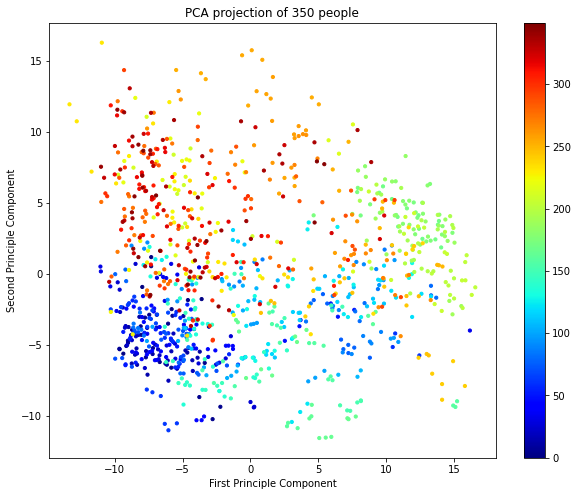

In [ ]:
number_of_people=350
index_range=number_of_people*10
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(1,1,1)
scatter=ax.scatter(X_pca[:index_range,0],
            X_pca[:index_range,1], 
            c=target[:index_range],
            s=10,
           cmap=plt.get_cmap('jet', number_of_people)
          )

ax.set_xlabel("First Principle Component")
ax.set_ylabel("Second Principle Component")
ax.set_title("PCA projection of {} people".format(number_of_people))

fig.colorbar(scatter)

50


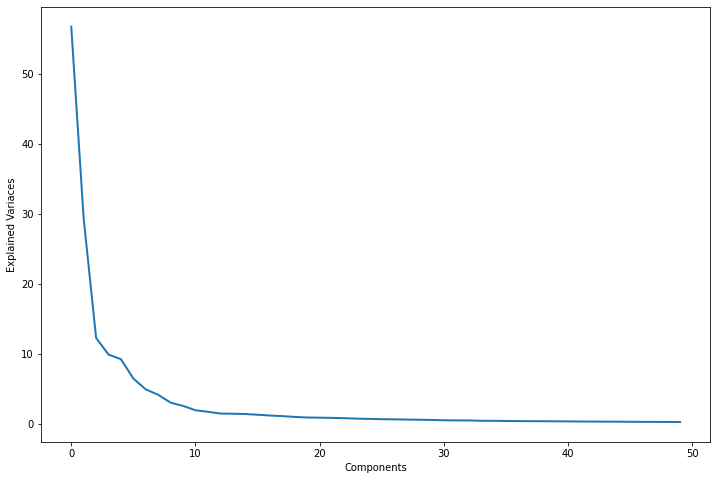

In [ ]:
pca = PCA(0.9) 
pca.fit(X)
print(pca.n_components_)

plt.figure(1, figsize=(12,8))

plt.plot(pca.explained_variance_, linewidth=2)
 
plt.xlabel('Components')
plt.ylabel('Explained Variaces')
plt.show()

In [ ]:
n_components = 50
pca=PCA(n_components=n_components, whiten=True)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

Text(0.5, 1.0, 'Average Face')

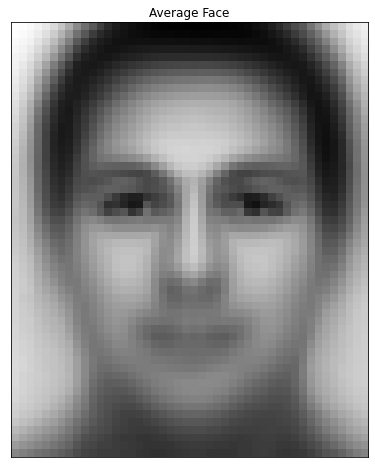

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
ax.imshow(pca.mean_.reshape((56,46)), cmap="gray")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Average Face')

50


Text(0.5, 0.98, 'All Eigen Faces')

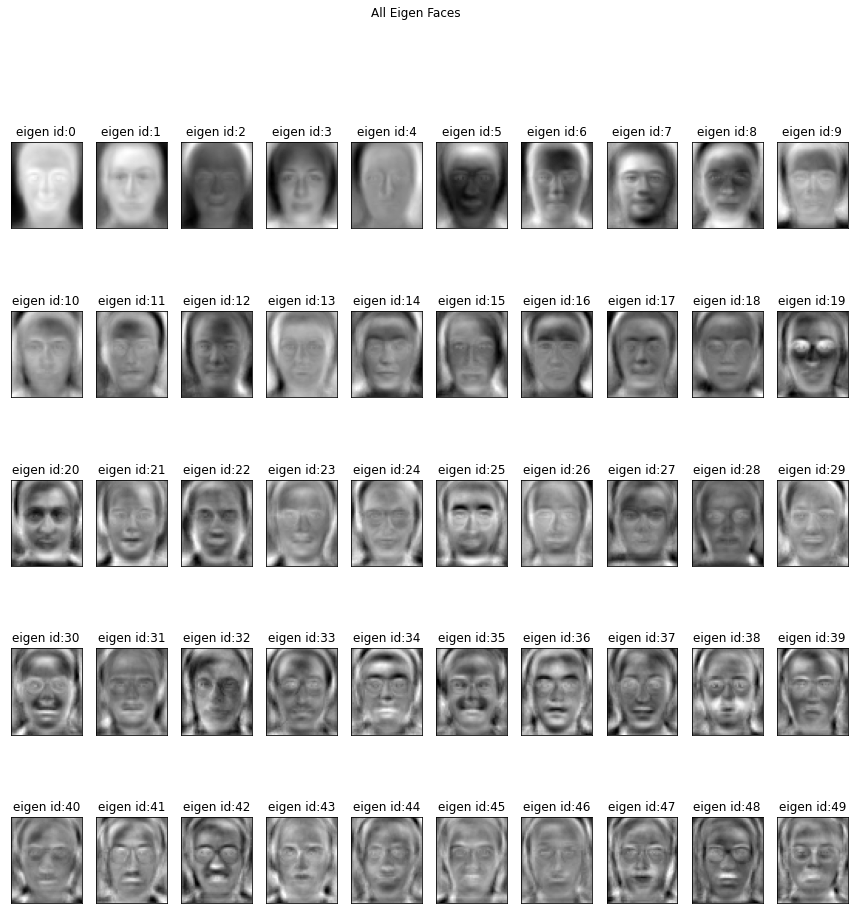

In [ ]:
number_of_eigenfaces=len(pca.components_)
eigen_faces=pca.components_.reshape((number_of_eigenfaces, data.shape[1], data.shape[2]))
print(number_of_eigenfaces)
cols=10
rows=int(number_of_eigenfaces/cols)
fig, axarr=plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))
axarr=axarr.flatten()
for i in range(number_of_eigenfaces):
    axarr[i].imshow(eigen_faces[i],cmap="gray")
    axarr[i].set_xticks([])
    axarr[i].set_yticks([])
    axarr[i].set_title("eigen id:{}".format(i))
plt.suptitle("All Eigen Faces".format(10*"=", 10*"="))

In [ ]:
X_train_pca=pca.transform(X_train)
X_test_pca=pca.transform(X_test)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (1024,)],
    'batch_size':[20, 100, 128, 512, 1024],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
} 

mlp= MLPClassifier(early_stopping=True, learning_rate_init=0.001, max_iter=10000, warm_start=False)
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=2)
clf.fit(X_train_pca, y_train)

print('Best parameters found:\n', clf.best_params_)
print('Best score found:\n', clf.best_score_)

model = clf.best_estimator_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)


Best parameters found:
 {'activation': 'logistic', 'alpha': 0.05, 'batch_size': 128, 'hidden_layer_sizes': (1024,), 'learning_rate': 'constant', 'solver': 'lbfgs'}
Best score found:
 0.6686217008797654


### Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kfold=KFold(n_splits=5, shuffle=True, random_state=3)
    
cv_scores=cross_val_score(model, X_train_pca, y_train, cv=kfold)

print("cross validations score:{:.2f}".format(cv_scores.mean()))

cross validations score:0.53


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

y_pred=clf.predict(X_test_pca)

print("Accuracy score:{:0.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("Recall score:{:0.2f}".format(metrics.recall_score(y_test, y_pred, average='macro')))
print("Precision score:{:0.2f}".format(metrics.precision_score(y_test, y_pred, average='macro')))
print("F1 score:{:0.2f}".format(metrics.f1_score(y_test, y_pred, average='macro')))

Accuracy score:0.81
Recall score:0.81
Precision score:0.77
F1 score:0.78


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
test_path = '/gdrive/My Drive/02_face_test'
test_file = []
x_test_data = []
width = 46
height = 56

for i in range(1,701):
    test_file.append(str(i)+'.bmp')

for file_name in test_file:
    file_path = '{}/{}'.format(test_path, file_name)
    image = Image.open(file_path).convert('L')
    image = image.resize((width, height))
    numpy_image = np.array(image)
    x_test_data.append(numpy_image/255.)

x_test_data = np.array(x_test_data)
x_test_data = x_test_data.reshape((x_test_data.shape[0],x_test_data.shape[1]*x_test_data.shape[2]))

test_pca=pca.transform(x_test_data) 

In [ ]:
predictions = clf.predict(test_pca)

y_pred = []

for i in range(len(predictions)):
    p = predictions[i]
    y_pred.append(p+1)

In [ ]:
import pandas as pd

plist = []

for i in range(1,701):
    plist.append(i)

columns = ["Image", "Answer"]
pred_df = pd.DataFrame([x for x in zip(plist, y_pred)], columns=columns)
pred_df

,Image,Answer
0,1,66
1,2,270
2,3,188
3,4,47
4,5,303
...,...,...
695,696,93
696,697,182
697,698,289
698,699,15
